In [519]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
from scipy.sparse import spdiags,linalg,eye
from tqdm import tqdm
import random

In [520]:
def initialconfig(N):
    
    '''Generates a hot start spin configuration as the initial condition'''
    state = 2*np.random.randint(2, size=(N,N))-1
    return state

def latticeupdate(latticeconfig, beta):

    '''One full lattice update (periodic BC) obtained using the Metropolis algorithm'''
    
    for i in range(N):
        for j in range(N):
            s = config[i, j]
            nb = latticeconfig[(i+1)%N, j] + latticeconfig[i, (j+1)%N] + latticeconfig[(i-1)%N, j] + latticeconfig[i, (j-1)%N]
            dE = 2*s*nb
            
            if dE < 0 or rand() < np.exp(-dE*beta):
                s *=-1
            config[i, j] = s
    return config

In [521]:
#Parameters
#-------------------

nt = 10         # number of temperature points
temp = 2.0 #setting the initial temperature
temp_step = 0.05    #temperature increasing step
stconfigs = 300    #number of configurations to be created at the same temperature
N = 64            # lattice size
eqSteps = 300     # thermalization time
mcSteps = 2**9     # number of MC sweeps for calculation

In [522]:
#Creation of the PCA matrix
#------------------------------

temperature = temp

for k in range(nt):
    for j in tqdm(range(stconfigs)):
        config = initialconfig(N)
        
        for i in range (eqSteps):
            latticeupdate(config, 1/temperature)
        
        row = config.flatten()
        if k==0 and j==0:
            PCAarr = row
        else:
            PCAarr = np.vstack([PCAarr,row])
    temperature += temp_step

100%|██████████| 300/300 [33:40<00:00,  6.74s/it]


In [523]:
#PCA implementation
#---------------------

PCAarr_mean = np.mean(PCAarr, axis=0)
PCAarr_centered = np.zeros((nt*stconfigs,N*N))

for i in range(N*N):
    PCAarr_centered[:,i] = PCAarr_mean[i]-PCAarr[:,i]

In [524]:
#Creating covariance matrix
#-------------------------------


PCAcov = np.cov(PCAarr_centered,rowvar=False)

In [525]:
#Eigenvalues and eigenvectors
#------------------------------


eigensystem = np.linalg.eig(PCAcov)

Text(0.5, 1.0, 'Correlation matrix eigenvalues')

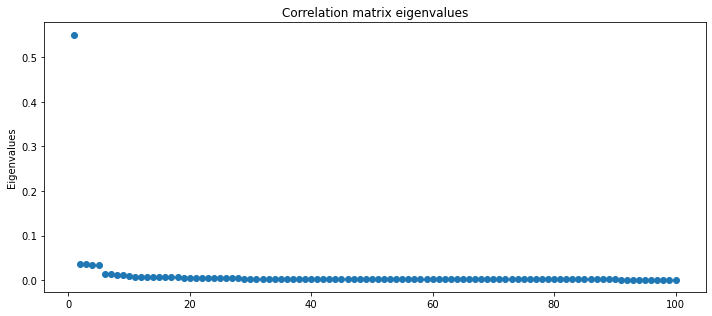

In [530]:
#Displaying eigenvalues and eigenvectors
#--------------------------------

sumeiv = sum(eigensystem[0][0:100])
n = []
for i in range(1,N*N+1):
  n.append(i)
plt.scatter(n[0:100],eigensystem[0][0:100]/sumeiv)
plt.ylabel("Eigenvalues")
plt.title("Correlation matrix eigenvalues")

In [540]:
#Projection on the first two principal components
#------------------------------


def reduce_system(U,dimension):
    U_reduced = U[:, :dimension]
    reduced_vec = np.dot(PCAarr_centered, U_reduced)
    return reduced_vec

reducevec = reduce_system(eigensystem[1],2)

temparray = np.zeros((nt*stconfigs, 1))
for i in range(nt):
    temparray[(i*stconfigs):((i+1)*stconfigs)] = (temp+i*temp_step) 

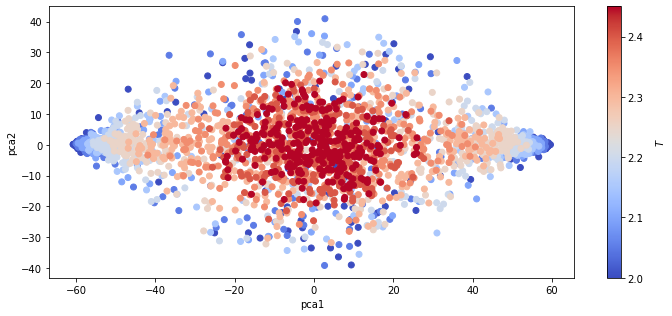

In [528]:
#Projection plot
#---------------------------


plt.scatter(reducevec[:,0],reducevec[:,1],c=temparray,cmap="coolwarm") 
plt.xlabel('pca1')
plt.ylabel('pca2')
cb = plt.colorbar()
cb.set_label(label='$T$',labelpad=10)

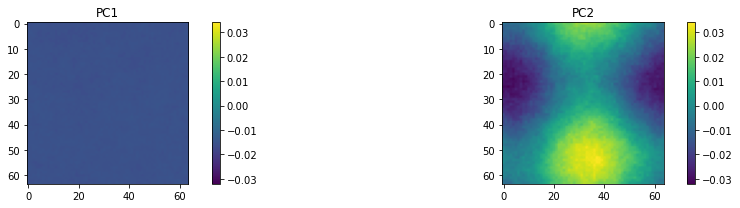

In [616]:
#Heatmap plot
#--------------------------------------------

eigen_vectors = eigensystem[1]

vmin = np.amin(eigen_vectors[:, 0:2])
vmax = np.amax(eigen_vectors[:, 0:2])

PCAw1 = np.reshape(np.real(eigen_vectors[:,0]), (N,N))
PCAw2 = np.reshape(np.real(eigen_vectors[:,1]), (N,N))

plt.figure(figsize=(20, 3))
plt.subplot(1, 3, 1)
plt.imshow(PCAw1[:, :], vmin=np.real(vmin), vmax=np.real(vmax))
plt.title('PC1')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(PCAw2[:,:], vmin=np.real(vmin), vmax=np.real(vmax))
plt.title('PC2')
plt.colorbar()

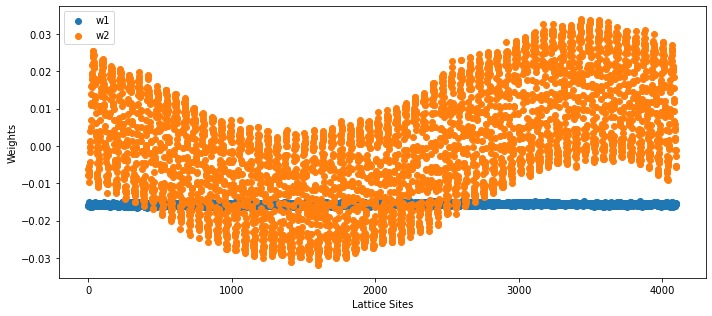

In [622]:
#ScatterPlot
#---------------------------



plt.scatter(n[0:(N*N)],np.real(eigen_vectors[:,0]),label = "w1")
plt.scatter(n[0:(N*N)],np.real(eigen_vectors[:,1]), label = "w2")
plt.ylabel("Weights")
plt.xlabel("Lattice Sites")
plt.legend(loc='upper left')
